In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras import regularizers
from PIL import Image

In [8]:
np.random.seed(42)

In [9]:
os.listdir('../Untitled Folder/archive (1)/Data/valid')

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
 'normal',
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

In [10]:
DATADIR = r'../Untitled Folder/archive (1)/Data/valid'

In [11]:
CATEGORIES = os.listdir(DATADIR)
CATEGORIES

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
 'normal',
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

In [12]:
def load_data():
    DATADIR = r'../Untitled Folder/archive (1)/Data/train'
    data = []
    # loading training data
    for category in CATEGORIES:
        # create path to image of respective expression
        path = os.path.join(DATADIR, category)
        # get the classification  for each expression 
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), 0)
            data.append([img_array, class_num])
            
    return data

In [13]:
data = load_data()

100%|███████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 235.82it/s]


In [14]:
len(data)

613

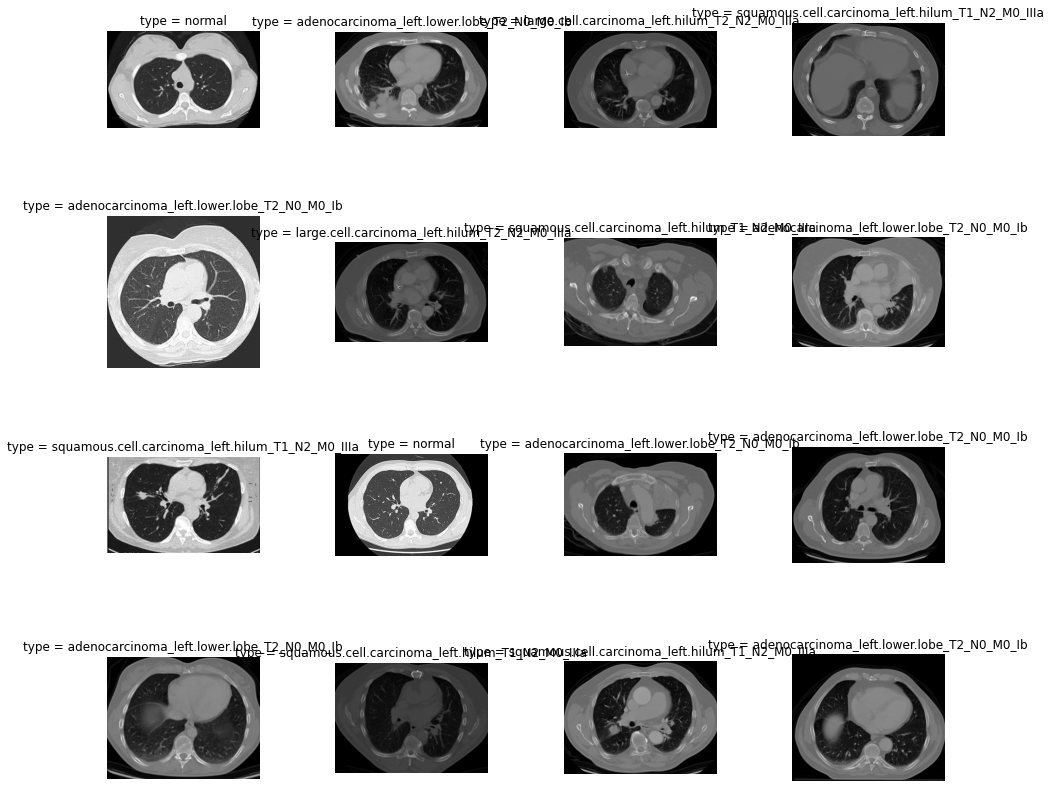

In [15]:
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (15,15))
axes = axes.ravel()

for i in range(0, L * W):  
    sample = random.choice(data)
    axes[i].set_title("type = "+str(CATEGORIES[sample[1]]))
    axes[i].imshow(sample[0], cmap='gray')
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [16]:
X = np.array([ x[0] for x in data])
y = np.array([Y[1] for Y in data])

<ipython-input-16-a7c15f6bb17e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array([ x[0] for x in data])


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [18]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("-------------------------------")
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (490,)
y_train shape:  (490,)
-------------------------------
X_test shape:  (123,)
y_test shape:  (123,)


In [19]:
y_train = np.reshape(y_train, (len(y_train),1))
y_test  = np.reshape(y_test , (len(y_test ),1))

print("After reshaping")
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

After reshaping
y_train shape:  (490, 1)
y_test shape:  (123, 1)


In [20]:
X_train_Gabor  = X_train
X_test_Gabor = X_test

In [21]:
y_train[0]

array([2])

In [22]:
y_train_SVM = y_train
y_test_SVM = y_test

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [23]:
y_train[0]

array([0., 0., 1., 0.], dtype=float32)

In [24]:
y_train.shape, y_test.shape

((490, 4), (123, 4))

In [25]:
def Gabor_filter(K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0):
    # get half size
    d = K_size // 2

    # prepare kernel
    gabor = np.zeros((K_size, K_size), dtype=np.float32)

    # each value
    for y in range(K_size):
        for x in range(K_size):
            # distance from center
            px = x - d
            py = y - d

            # degree -> radian
            theta = angle / 180. * np.pi

            # get kernel x
            _x = np.cos(theta) * px + np.sin(theta) * py

            # get kernel y
            _y = -np.sin(theta) * px + np.cos(theta) * py

            # fill kernel
            gabor[y, x] = np.exp(-(_x**2 + Gamma**2 * _y**2) / (2 * Sigma**2)) * np.cos(2*np.pi*_x/Lambda + Psi)

    # kernel normalization
    gabor /= np.sum(np.abs(gabor))

    return gabor


# Use Gabor filter to act on the image
def Gabor_filtering(gray, K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0):
    # get shape
    H, W = gray.shape

    # padding
    gray = np.pad(gray, (K_size//2, K_size//2), 'edge')

    # prepare out image
    out = np.zeros((H, W), dtype=np.float32)

    # get gabor filter
    gabor = Gabor_filter(K_size=K_size, Sigma=Sigma, Gamma=Gamma, Lambda=Lambda, Psi=0, angle=angle)

    # filtering
    for y in range(H):
        for x in range(W):
            out[y, x] = np.sum(gray[y : y + K_size, x : x + K_size] * gabor)

    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)

    return out


# Use 6 Gabor filters with different angles to perform feature extraction on the image
def Gabor_process(img):
#     print(img.shape)
    # get shape
    H, W = img.shape

    # gray scale
#     gray = BGR2GRAY(img).astype(np.float32)

    # define angle
    #As = [0, 45, 90, 135]
    As = [0,30,60,90,120,150]

    # prepare pyplot
#     plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0.2)

    out = np.zeros([H, W], dtype=np.float32)

    # each angle
    for i, A in enumerate(As):
    
        # gabor filtering
        _out = Gabor_filtering(img, K_size=11, Sigma=1.5, Gamma=1.2, Lambda=3, angle=A)
         

        # add gabor filtered image
        out += _out
        

    # scale normalization
    out = out /out.max()*255
    out = out.astype(np.uint8)

    return out

In [26]:
def create_Gabor_features(data):
    Feature_data = np.zeros((len(data),48,48,1))

    for i in range(len(data)):
        img = data[i]
        out = Gabor_process(img)
        out = np.expand_dims(out , axis = 2) # adding color channel
        Feature_data[i] = out/255.00

        
    return Feature_data 

In [27]:
X_train.shape

(490,)

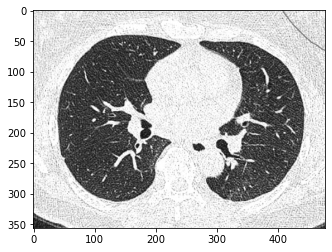

In [28]:
plt.imshow(X_train_Gabor[0]/255.0, cmap ='gray')

(-0.5, 424.5, 300.5, -0.5)

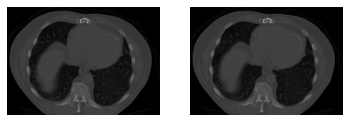

In [29]:
sample = random.randint(10,50)
plt.subplot(1,2,1)
plt.imshow(X_train[sample],cmap='gray')
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(X_train_Gabor[sample],cmap='gray')
plt.axis("off")

In [30]:
X_train_Gabor.shape

(490,)

In [5]:
samp1 = Image.open('archive (1)/__results___44_0.png')

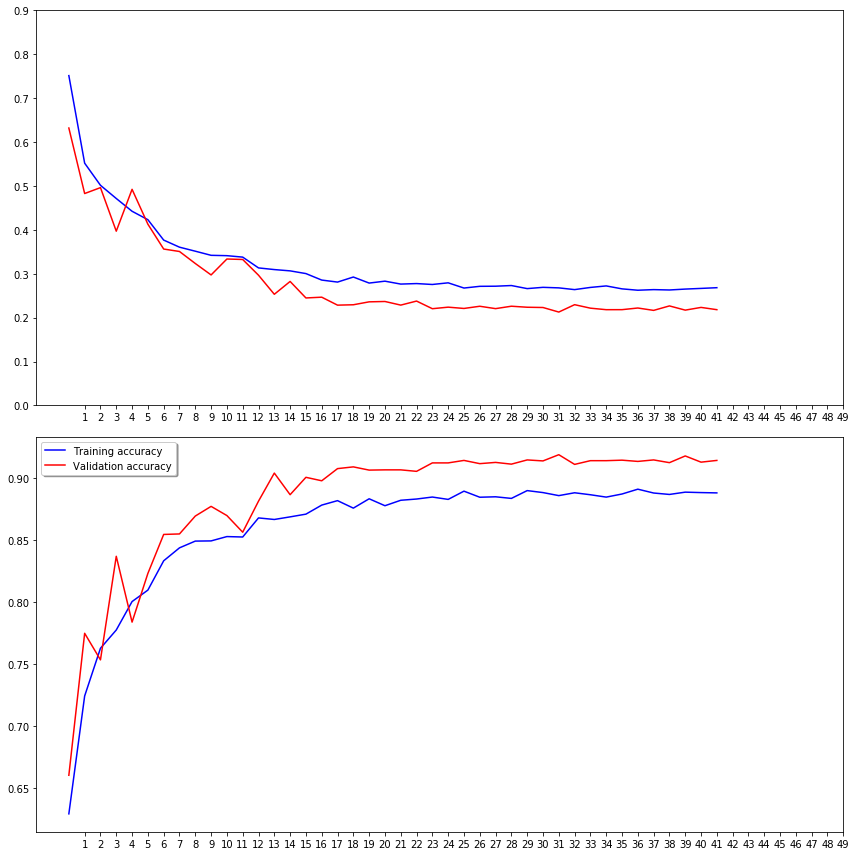

In [7]:
np_array = np.asarray(samp1)
samp1